# Zaawansowane Uczenie Maszynowe - Projekt

Tworzenie zespołu modeli klasyfikacji przez wielokrotne stosowanie dowolnego algorytmu klasyfikacji do bootstrapowych prób ze zbioru trenującego, przy użyciu jako dodatkowych mechanizmów różnicowania modeli losowej selekcji podzbiorów atrybutów oraz losowego ustalenia hiperparametrów. Porównanie z wybranymi algorytmami klasyfikacji tworzącymi pojedyncze modele oraz implementacjami algorytmów bagging i random forest dostępnymi w środowisku R lub Python.

Powyższy temat koncentruje się na tworzeniu zespołu modeli poprzez wielokrotne trenowanie pojedynczego algorytmu na różnych podzbiorach danych, uzyskanych metodą bootstrapingu. Istotnym aspektem tego rozwiązania jest wprowadzenie dodatkowej losowości, która ma na celu zwiększenie różnorodności i uodpornienia modeli na nadmierne dopasowanie.



# Datasets Overview

W tym projekcie analizujemy trzy różne zbiory danych:


# Flight Satisfaction Dataset
Zbiór danych klasyfikacji binarnej zawierający dane o zadowoleniu pasażerów z lotów. Cechy obejmują odległość lotu, opóźnienia przylotu/odlotu, oceny usług podczas lotu oraz dane demograficzne pasażerów. Zmienna docelowa to zadowolenie pasażera (zadowolony/niezadowolony).

### Zbiory danych treningowych

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from collections import Counter
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import seaborn as sns

CURR_FILE_NAME = "test.csv" # or test.csv
TARGET_CLASS_NAME = "satisfaction"

colors = ["#0101DF", "#DF0101"]

In [ ]:

def load_data(path):
  if path is None or path == "":
    raise ValueError("Dataset path is invalid")
  elif not os.path.exists(path):
    raise FileNotFoundError(f"Dataset not found at path: {path}")

  train_path = os.path.join(path, CURR_FILE_NAME)

  return pd.read_csv(train_path)

In [ ]:
def plot_distributions(df, class_names):
  for class_name in class_names:
    df_frist_class = df[class_name]
    fig1, ax1 = plt.subplots(figsize=(9, 5))
    sns.distplot(df_frist_class.values, ax=ax1, color='r')
    ax1.set_title('Distribution of ' + class_name, fontsize=14)
    ax1.set_xlim([df_frist_class.min(), df_frist_class.max()])
    plt.show()

### Balanced airflight satisfaction



In [ ]:
df = load_data("data/raw/binary_balanced_airflight_satisfaction")

In [ ]:
#dropping id and unnamed column
df = df.drop(df.iloc[:,[0, 1]], axis = 1)

# Conver all special characters and whitespace  to underscores
df.columns = df.columns.str.replace(r'[^\w\s]', '_').str.replace(r'\s+', '_').str.lower()

df.columns

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_85068/1199417295.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_85068/1199417295.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.



Index(['gender', 'customer_type', 'age', 'type_of_travel', 'class',
       'flight_distance', 'inflight_wifi_service',
       'departure_arrival_time_convenient', 'ease_of_online_booking',
       'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort',
       'inflight_entertainment', 'on_board_service', 'leg_room_service',
       'baggage_handling', 'checkin_service', 'inflight_service',
       'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes',
       'satisfaction'],
      dtype='object')

In [ ]:
categorical_indexes = [0, 1, 3, 4] + list(range(6, 20))
df.iloc[:, categorical_indexes] = df.iloc[:, categorical_indexes].astype('category')
df.info()


/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_85068/3669382306.py:2: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   gender                             25976 non-null  category
 1   customer_type                      25976 non-null  category
 2   age                                25976 non-null  int64   
 3   type_of_travel                     25976 non-null  category
 4   class                              25976 non-null  category
 5   flight_distance                    25976 non-null  int64   
 6   inflight_wifi_service              25976 non-null  category
 7   departure_arrival_time_convenient  25976 non-null  category
 8   ease_of_online_booking             25976 non-null  category
 9   gate_location                      25976 non-null  category
 10  food_and_drink                     25976 non-null  category
 11  online_boarding                    25976 

In [ ]:
df.head()

,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,...,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,Female,Loyal Customer,52,Business travel,Eco,160,5,4,3,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,Female,Loyal Customer,36,Business travel,Business,2863,1,1,3,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,Male,disloyal Customer,20,Business travel,Eco,192,2,0,2,4,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,Male,Loyal Customer,44,Business travel,Business,3377,0,0,0,2,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,4,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [ ]:
df.shape

(25976, 23)

In [ ]:
#display sum of cells having null value and column name
null_counts = df.isnull().sum()
max_nulls = null_counts.max()
max_null_col = null_counts[null_counts == max_nulls].index[0] if max_nulls > 0 else "No nulls"
display(f"Maximum null values: {max_nulls} in column: {max_null_col}")
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(df.isna().sum().sum()))
df.info()

'Maximum null values: 83 in column: arrival_delay_in_minutes'

Null Values In DataFrame: 83

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   gender                             25976 non-null  category
 1   customer_type                      25976 non-null  category
 2   age                                25976 non-null  int64   
 3   type_of_travel                     25976 non-null  category
 4   class                              25976 non-null  category
 5   flight_distance                    25976 non-null  int64   
 6   inflight_wifi_service              25976 non-null  category
 7   departure_arrival_time_convenient  25976 non-null  category
 8   ease_of_online_booking             25976 non-null  category
 9   gate_location                      25976 non-null  category
 10  food_and_drink                     25976 non-null  category
 11  online_boar

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_85068/4199844963.py:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



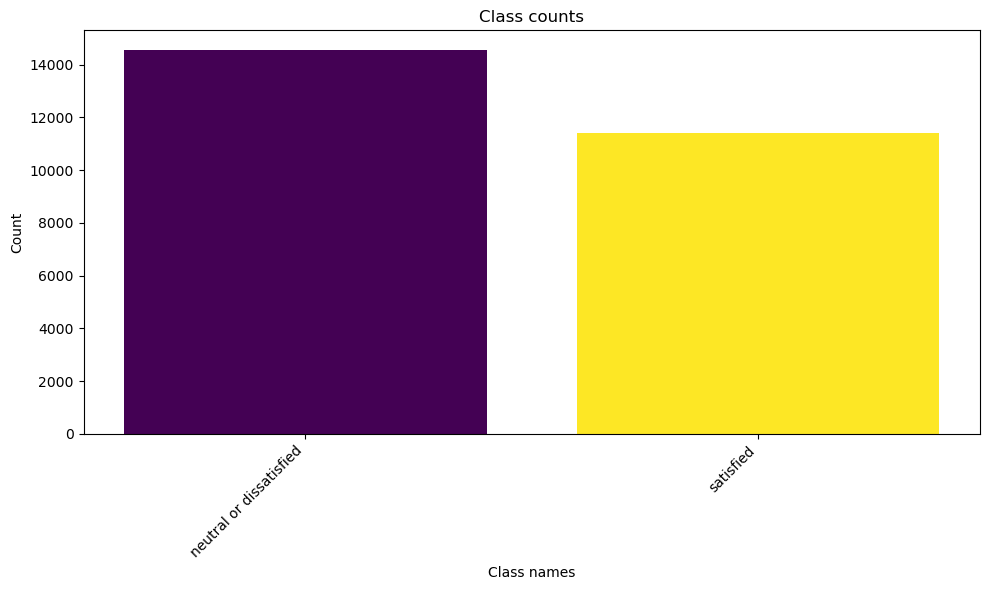

In [ ]:
label_col = df[TARGET_CLASS_NAME]

# Plotting data
label_counts = label_col.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

plt.figure(figsize=(10, 6)) # Create a new figure and set its size
plt.bar(label_counts.index, label_counts.values, color=colors) # Create a bar plot
plt.title('Class counts') # Set the title of the plot
plt.xlabel('Class names') # Set the label for the x-axis
plt.ylabel('Count') # Set the label for the y-axis
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the plot

In [ ]:
df.describe(include='all')

,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,...,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
count,25976,25976,25976.000000,25976,25976,25976.000000,25976.0,25976.0,25976.0,25976.0,...,25976.0,25976.0,25976.0,25976.0,25976.0,25976.0,25976.0,25976.00000,25893.000000,25976
unique,2,2,NaN,2,3,NaN,6.0,6.0,6.0,5.0,...,6.0,6.0,6.0,5.0,5.0,6.0,6.0,NaN,NaN,2
top,Female,Loyal Customer,NaN,Business travel,Business,NaN,2.0,4.0,2.0,3.0,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,NaN,NaN,neutral or dissatisfied
freq,13172,21177,NaN,18038,12495,NaN,6490.0,6334.0,6030.0,7140.0,...,7368.0,7836.0,7097.0,9378.0,7278.0,9378.0,6790.0,NaN,NaN,14573
mean,NaN,NaN,39.620958,NaN,NaN,1193.788459,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.30609,14.740857,NaN
std,NaN,NaN,15.135685,NaN,NaN,998.683999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.42316,37.517539,NaN
min,NaN,NaN,7.000000,NaN,NaN,31.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,NaN
25%,NaN,NaN,27.000000,NaN,NaN,414.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,NaN
50%,NaN,NaN,40.000000,NaN,NaN,849.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,NaN
75%,NaN,NaN,51.000000,NaN,NaN,1744.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.00000,13.000000,NaN


### Filling missing values

In [ ]:
df['arrival_delay_in_minutes'].fillna(df['arrival_delay_in_minutes'].median(axis = 0), inplace = True)

In [ ]:
print(df.isnull().sum())

gender                               0
customer_type                        0
age                                  0
type_of_travel                       0
class                                0
flight_distance                      0
inflight_wifi_service                0
departure_arrival_time_convenient    0
ease_of_online_booking               0
gate_location                        0
food_and_drink                       0
online_boarding                      0
seat_comfort                         0
inflight_entertainment               0
on_board_service                     0
leg_room_service                     0
baggage_handling                     0
checkin_service                      0
inflight_service                     0
cleanliness                          0
departure_delay_in_minutes           0
arrival_delay_in_minutes             0
satisfaction                         0
dtype: int64


/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_85068/881755835.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




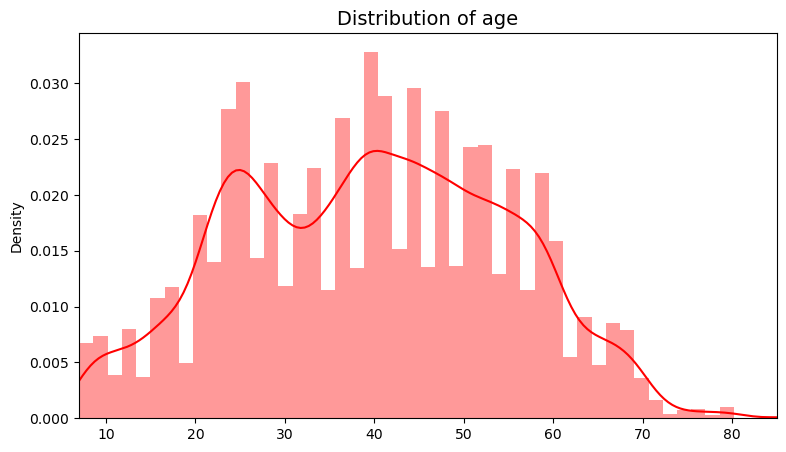

<Figure size 1200x800 with 0 Axes>

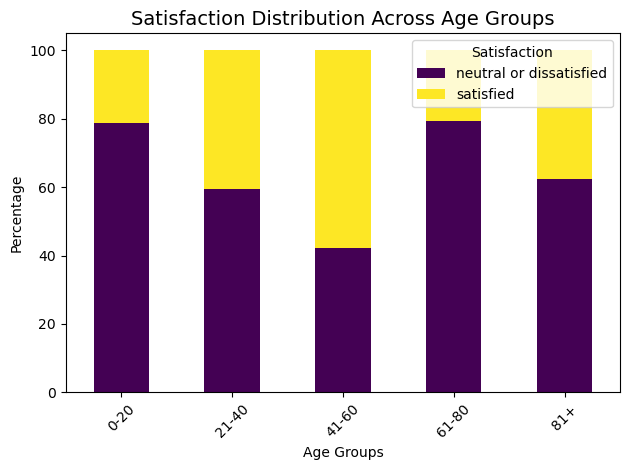

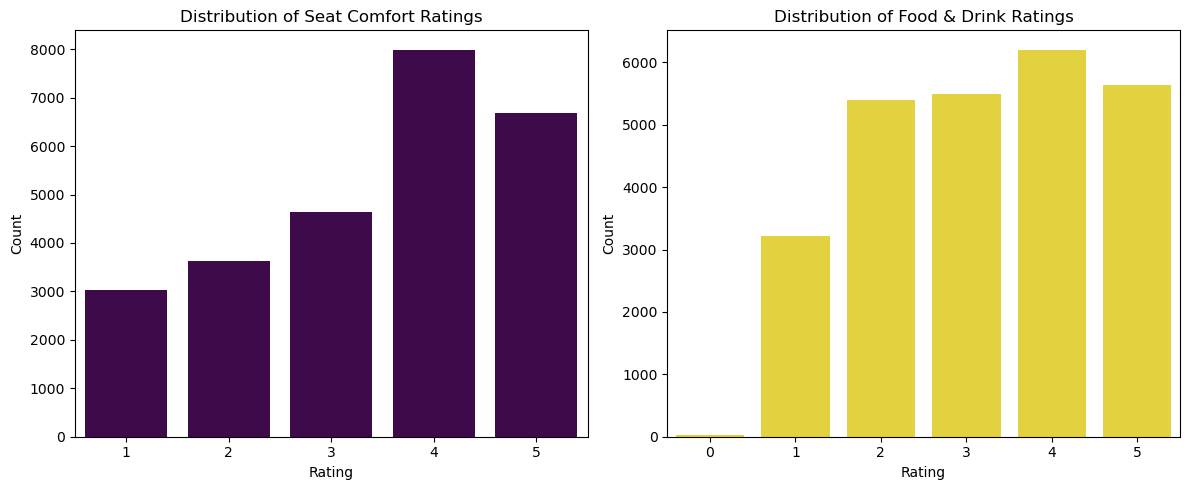

14


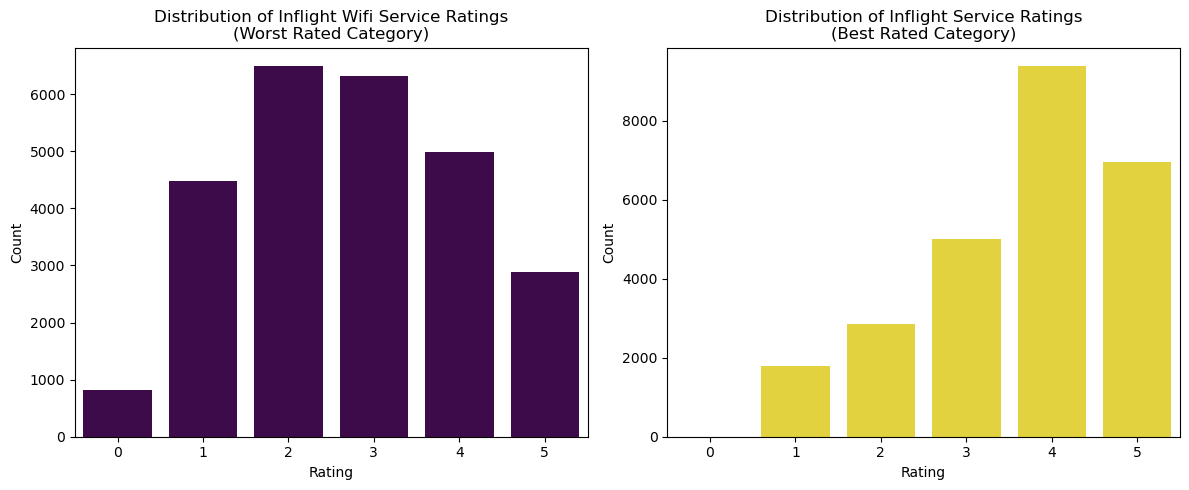

In [ ]:
plot_distributions(df, ['age'])

# Create age groups for more detailed analysis
df['age_group'] = pd.cut(df['age'], bins=[0,20,40,60,80,100], labels=['0-20','21-40','41-60','61-80','81+'])

# Plot satisfaction distribution across age groups
plt.figure(figsize=(12,8))
satisfaction_by_age_group = pd.crosstab(df['age_group'], df['satisfaction'], normalize='index') * 100

satisfaction_by_age_group.plot(kind='bar', stacked=True, color=colors)
plt.title('Satisfaction Distribution Across Age Groups', fontsize=14)
plt.xlabel('Age Groups')
plt.ylabel('Percentage')
plt.legend(title='Satisfaction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Drop age_group column
df = df.drop('age_group', axis=1)


# Plot distribution of ratings for seat comfort and food/drink
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(data=df, x='seat_comfort', color=colors[0])
plt.title('Distribution of Seat Comfort Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1,2,2) 
sns.countplot(data=df, x='food_and_drink', color=colors[1])
plt.title('Distribution of Food & Drink Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Create a pass of size for categorical columns
all_categorical_columns = [col for col in df.columns if df[col].dtype == 'category']
exclude_columns = ['gender', 'type_of_travel', 'customer_type', 'class', 'age', 'flight_distance', 'arrival_delay_in_minutes', 'departure_delay_in_minutes', 'satisfaction']
service_columns = [col for col in all_categorical_columns if col not in exclude_columns]


# Calculate mean rating for each service category
df_numeric = df[service_columns].dropna().astype('int')
service_means = df_numeric.mean().sort_values()
print(len(service_means))
# Get worst and best rated categories
worst_category = service_means.index[0]
best_category = service_means.index[-1]

# Plot distributions
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.countplot(data=df, x=worst_category, color=colors[0])
plt.title(f'Distribution of {worst_category.replace("_"," ").title()} Ratings\n(Worst Rated Category)')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.subplot(1,2,2)
sns.countplot(data=df, x=best_category, color=colors[1]) 
plt.title(f'Distribution of {best_category.replace("_"," ").title()} Ratings\n(Best Rated Category)')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()




/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_85068/781441867.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



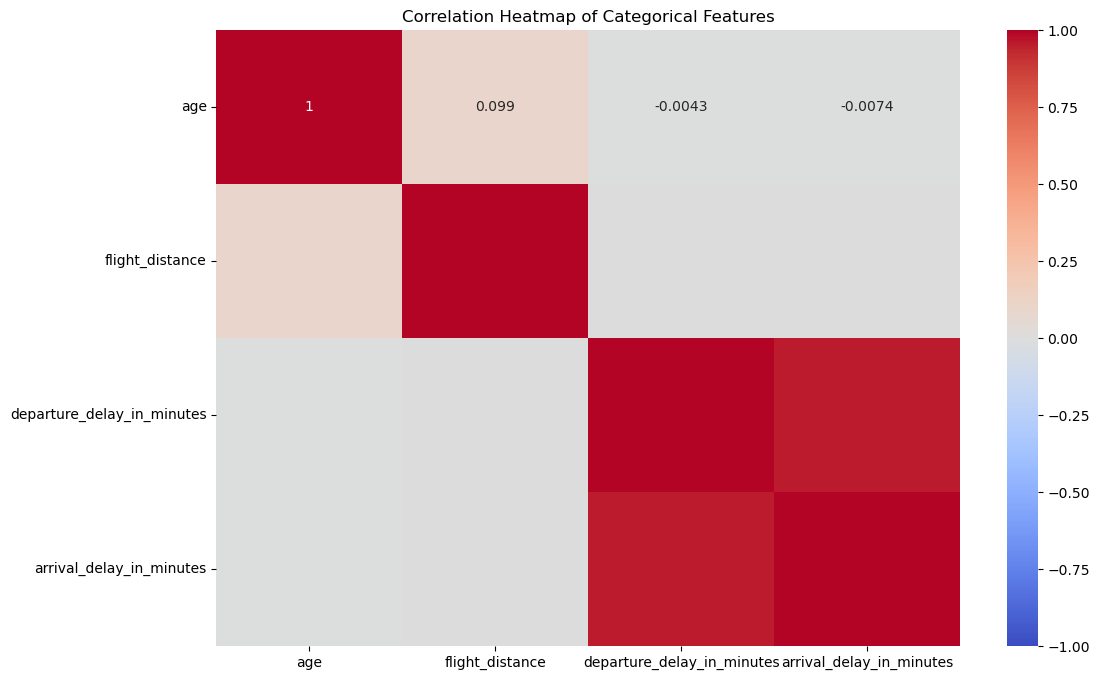

In [ ]:
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Categorical Features')
plt.show()



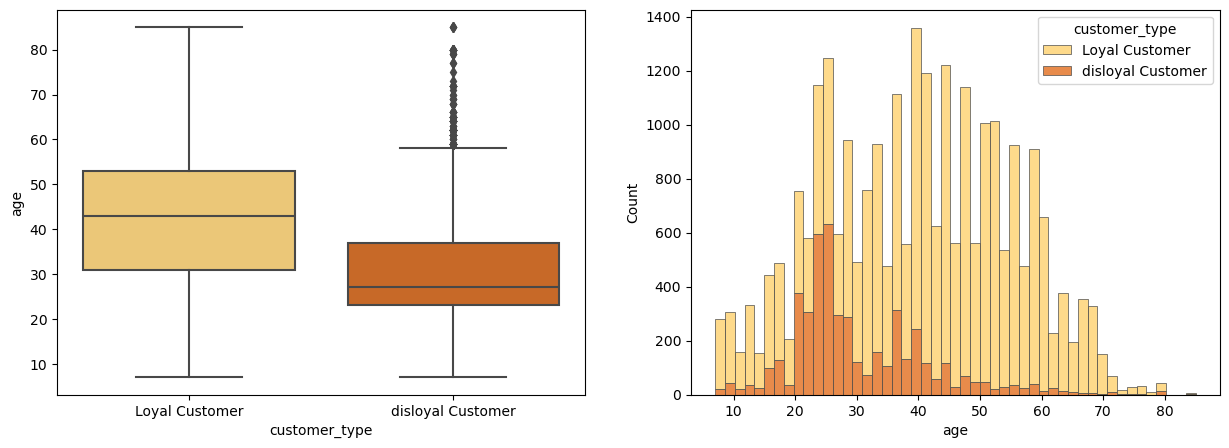

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "customer_type", y = "age", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "age", hue = "customer_type", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

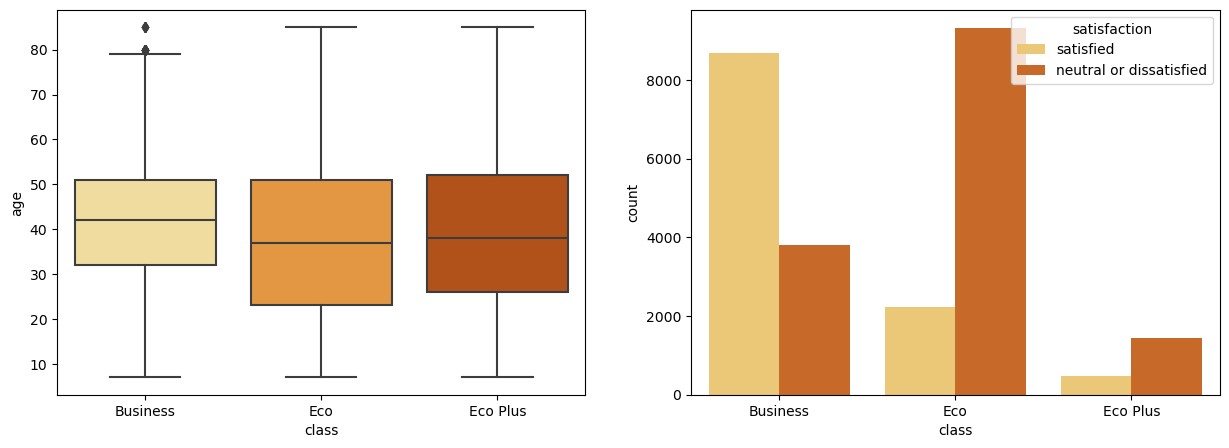

In [ ]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "class", y = "age", palette="YlOrBr", data = df, ax = ax[0])
sns.countplot(x = "class", hue = "satisfaction", palette = "YlOrBr", data=df)
pass



In [ ]:

from sklearn.preprocessing import LabelEncoder

df = df.dropna(subset=[TARGET_CLASS_NAME])
        # Handle missing values in features
for col in df.columns:
    if col != TARGET_CLASS_NAME:
        if df[col].dtype in ['object', 'category']:
            # Fill categorical missing values with mode
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'unknown')
        else:
            # Fill numerical missing values with median
            df[col] = df[col].fillna(df[col].median())

# Encode categorical variables
label_encoders = {}
for col in df.columns:
    if df[col].dtype in ['object', 'category']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le


In [ ]:
df.shape

(25976, 23)

### Save processed dataset to CSV

In [ ]:
# Save train or test datasets
df.to_csv('data/processed/binary_balanced_airflight_satisfaction/' + CURR_FILE_NAME, index=False)

print("Dataset set shape: ", df.shape)
print("Dataset saved to: ", 'data/processed/binary_balanced_airflight_satisfaction/' + CURR_FILE_NAME)

Dataset set shape:  (25976, 23)
Dataset saved to:  data/processed/binary_balanced_airflight_satisfaction/test.csv


# Credit Card Fraud Dataset 
Mocno niezbalansowany zbiór danych klasyfikacji binarnej do wykrywania oszukańczych transakcji kartami kredytowymi. Cechy to wartości numeryczne po transformacji PCA ze względu na prywatność. Zmienna docelowa wskazuje, czy transakcja jest oszukańcza czy legalna.

### Zbiory danych treningowych

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from collections import Counter
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import seaborn as sns


TRAIN_FILE_NAME = "train.csv"
TEST_FILE_NAME = "test.csv"
TARGET_CLASS_NAME = "class"

colors = ["#0101DF", "#DF0101"]

In [ ]:

def load_data(path):
  if path is None or path == "":
    raise ValueError("Dataset path is invalid")
  elif not os.path.exists(path):
    raise FileNotFoundError(f"Dataset not found at path: {path}")

  train_path = os.path.join(path, TRAIN_FILE_NAME)

  df = pd.read_csv(train_path)
  return df.sample(frac=0.8, random_state=42) # file size must not exceed 100MB in GitHub

In [ ]:
def analyze_data(df, class_column_key):
  #display shape
  display(df.shape)
  #display sum of cells having null value and column name
  null_counts = df.isnull().sum()
  max_nulls = null_counts.max()
  max_null_col = null_counts[null_counts == max_nulls].index[0] if max_nulls > 0 else "No nulls"
  display(f"Maximum null values: {max_nulls} in column: {max_null_col}")
  # Get null values and dataframe information
  print('Null Values In DataFrame: {}\n'.format(df.isna().sum().sum()))
  display(df.info())

  label_col = df[class_column_key]

  # Plotting data
  label_counts = label_col.value_counts()

  # Get colors
  n = label_counts.shape[0]
  colormap = get_cmap('viridis')
  colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

  plt.figure(figsize=(10, 6)) # Create a new figure and set its size
  plt.bar(label_counts.index, label_counts.values, color=colors) # Create a bar plot
  plt.title('Class counts') # Set the title of the plot
  plt.xlabel('Class names') # Set the label for the x-axis
  plt.ylabel('Count') # Set the label for the y-axis
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.show() # Display the plot

  display(df.describe(include='all'))

### Unbalanced credit card frauds

In [ ]:
df = load_data("data/raw/binary_unbalanced_credit_card_fraud")
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [ ]:
#rename columns to lower case
df.columns = df.columns.str.lower()
df.head()

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [ ]:
print('No Frauds', round(df['class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
num_of_frauds = df['class'].value_counts()[1]
print('Frauds', round(num_of_frauds/len(df) * 100,2), '% of the dataset')
print('Number of fraud transactions', num_of_frauds)

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Number of fraud transactions 387


### Analyze columns and nulls


(227846, 31)

'Maximum null values: 0 in column: No nulls'

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227846 entries, 43428 to 213180
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    227846 non-null  float64
 1   v1      227846 non-null  float64
 2   v2      227846 non-null  float64
 3   v3      227846 non-null  float64
 4   v4      227846 non-null  float64
 5   v5      227846 non-null  float64
 6   v6      227846 non-null  float64
 7   v7      227846 non-null  float64
 8   v8      227846 non-null  float64
 9   v9      227846 non-null  float64
 10  v10     227846 non-null  float64
 11  v11     227846 non-null  float64
 12  v12     227846 non-null  float64
 13  v13     227846 non-null  float64
 14  v14     227846 non-null  float64
 15  v15     227846 non-null  float64
 16  v16     227846 non-null  float64
 17  v17     227846 non-null  float64
 18  v18     227846 non-null  float64
 19  v19     227846 non-null  float64
 20  v20     227846 

None

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_76797/2670232780.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



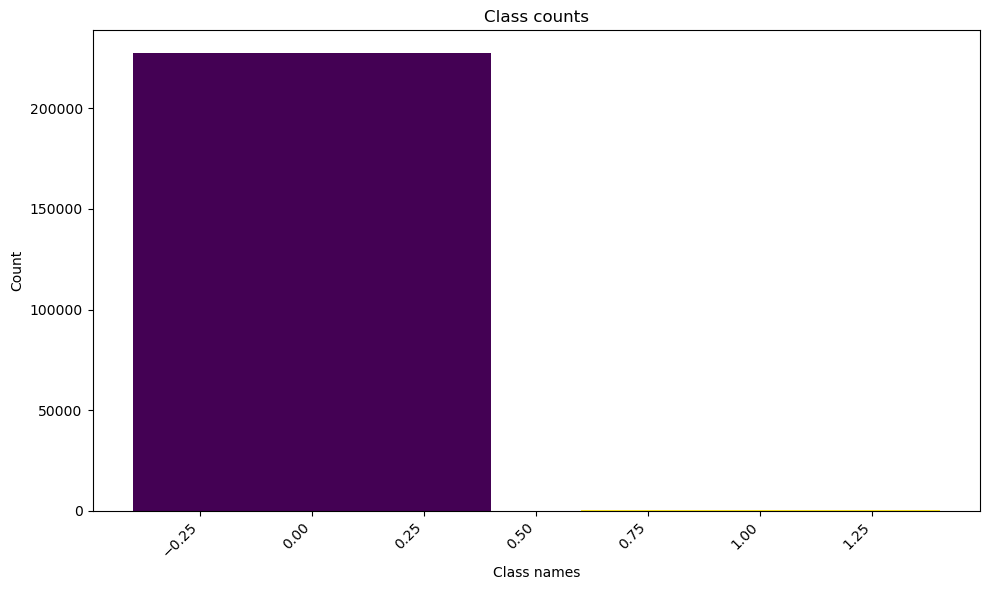

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
count,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,...,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000,227846.000000
mean,94878.135403,0.003417,0.002014,0.000485,0.000079,0.000091,-0.001396,-0.000349,-0.000033,-0.001121,...,0.000524,-0.000953,-0.000134,-0.000457,0.000899,-0.000080,0.000026,0.000055,87.890337,0.001699
std,47487.612836,1.951477,1.632831,1.511987,1.414350,1.360711,1.323366,1.217531,1.198509,1.098270,...,0.738604,0.725281,0.626764,0.605221,0.520714,0.481668,0.398954,0.324199,238.806140,0.041178
min,0.000000,-46.855047,-60.464618,-33.680984,-5.683171,-42.147898,-23.496714,-41.506796,-73.216718,-13.434066,...,-34.830382,-9.499423,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54224.000000,-0.918903,-0.596600,-0.890425,-0.848205,-0.691445,-0.770017,-0.553157,-0.208821,-0.643276,...,-0.228295,-0.543157,-0.161937,-0.354525,-0.316886,-0.326533,-0.070766,-0.052799,5.520000,0.000000
50%,84793.500000,0.021103,0.065595,0.180289,-0.018959,-0.053240,-0.275132,0.040044,0.022233,-0.051956,...,-0.029798,0.006449,-0.011093,0.040527,0.018175,-0.052024,0.001296,0.011200,22.000000,0.000000
75%,139366.000000,1.316328,0.803540,1.027265,0.744322,0.612325,0.398199,0.569602,0.326577,0.594780,...,0.186244,0.527882,0.147648,0.438460,0.351476,0.239792,0.090715,0.078090,77.097500,0.000000
max,172792.000000,2.451888,21.467203,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.083545,4.022866,7.519589,3.517346,12.152401,22.620072,18910.000000,1.000000


In [ ]:
analyze_data(df, 'class')

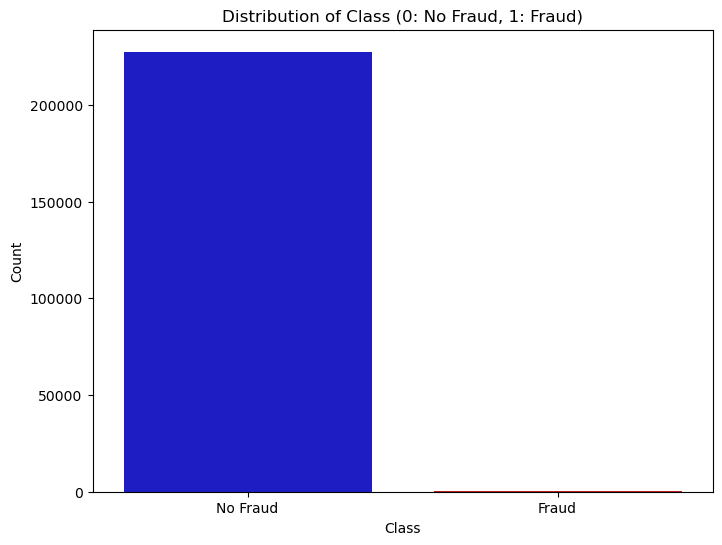

In [ ]:
# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df, palette=colors)
plt.title('Distribution of Class (0: No Fraud, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Fraud', 'Fraud']) # Explicitly label the x-ticks
plt.show()

In [ ]:
def plot_distributions(df, class_names):
  for class_name in class_names:
    df_frist_class = df[class_name]
    fig1, ax1 = plt.subplots(figsize=(9, 5))
    sns.distplot(df_frist_class.values, ax=ax1, color='r')
    ax1.set_title('Distribution of ' + class_name, fontsize=14)
    ax1.set_xlim([df_frist_class.min(), df_frist_class.max()])
    plt.show()

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_76797/881755835.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




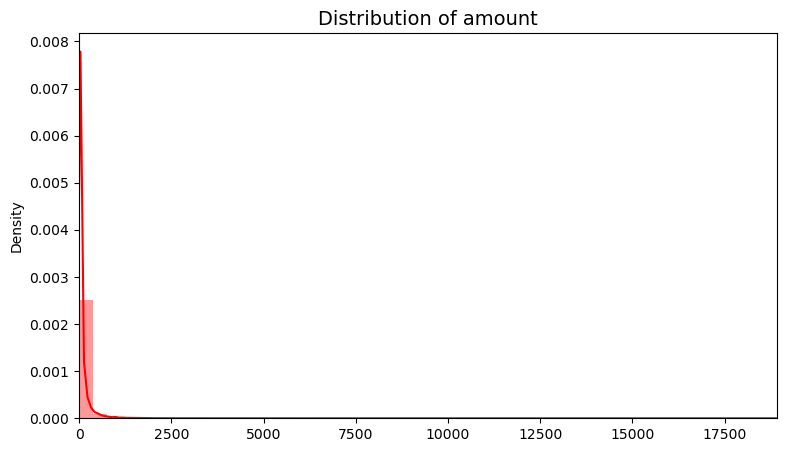

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_76797/881755835.py:5: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




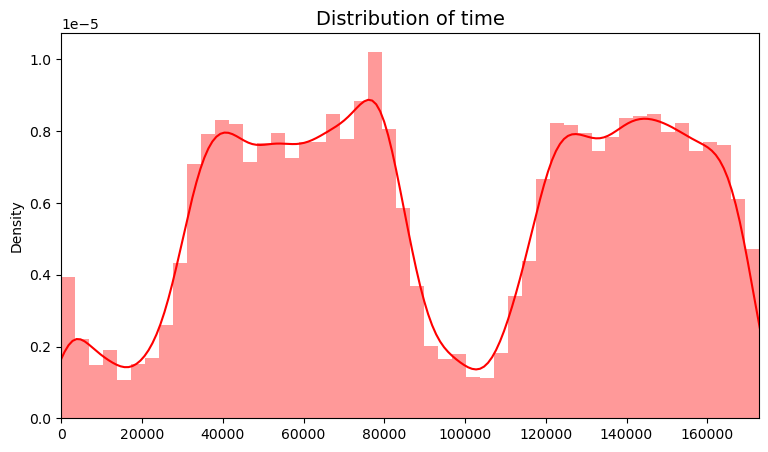

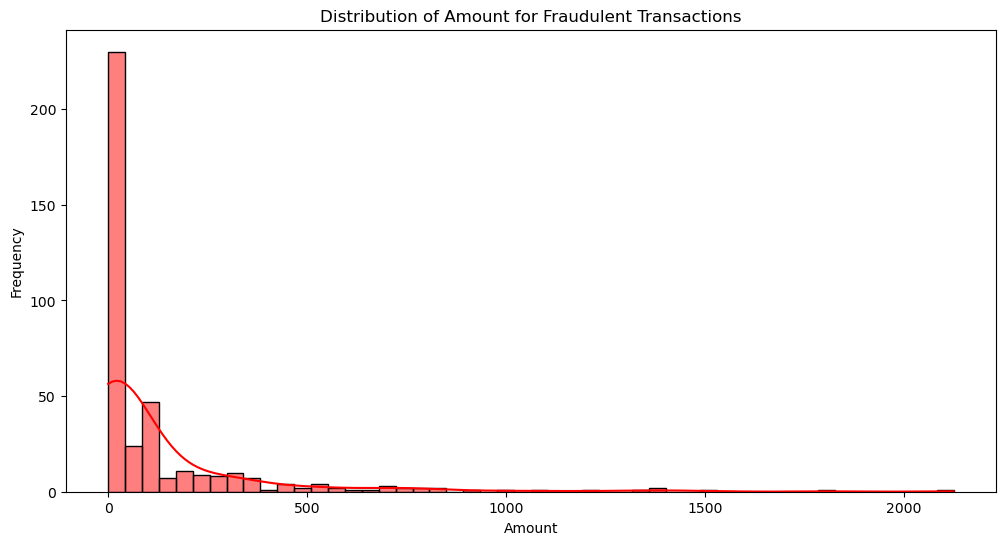

In [ ]:
plot_distributions(df, ['amount', 'time'])

# Plot distribution of Amount for fraudulent transactions only
df_third_class = df['class']
plt.figure(figsize=(12, 6))
sns.histplot(data=df[df['class'] == 1], x='amount', bins=50, kde=True, color='red', stat='count')
plt.title('Distribution of Amount for Fraudulent Transactions')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['time'].values.reshape(-1,1))

df.drop(['time','amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,v1,v2,v3,v4,v5,v6,v7,v8,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,class
43428,4.780692,-0.508427,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1
49906,6.959170,-0.476058,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,0
29474,0.125738,-0.579144,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0
276481,-0.286403,0.966967,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,0
278846,-0.294925,0.982823,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0


Distribution of the classes in the subsampled dataset:
1    0.5
0    0.5
Name: class, dtype: float64


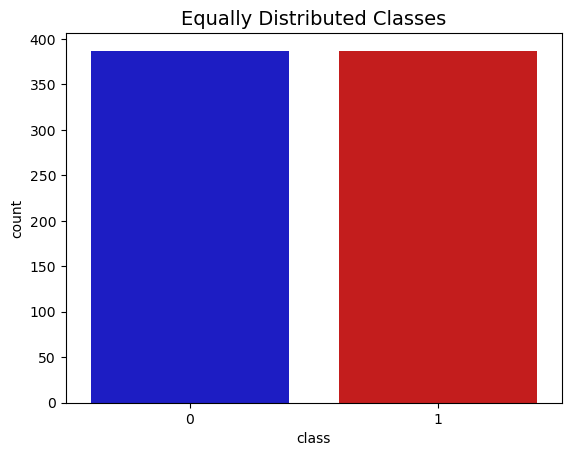

In [ ]:
df = df.sample(frac=1)

fraud_df = df.loc[df['class'] == 1]
non_fraud_df = df.loc[df['class'] == 0][:num_of_frauds]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

new_shuffled_df = normal_distributed_df.sample(frac=1, random_state=42)

new_shuffled_df.head()

print('Distribution of the classes in the subsampled dataset:')
print(new_shuffled_df['class'].value_counts() / len(new_shuffled_df))

sns.countplot(x='class', data=new_shuffled_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [ ]:
df.head()

,scaled_amount,scaled_time,v1,v2,v3,v4,v5,v6,v7,v8,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,class
113368,-0.257343,-0.138046,-0.612282,1.132224,1.234392,-0.192202,0.060297,-0.658193,0.617158,0.024300,...,0.180147,-0.302543,-0.779244,-0.068306,-0.160487,-0.106357,0.109851,0.369267,0.172247,0
59421,-0.293388,-0.422394,1.257913,0.597510,-0.578114,0.992278,0.510822,-0.376638,0.178060,-0.043906,...,-0.064133,-0.056782,-0.122684,-0.239118,-0.642818,0.778060,-0.291457,0.027178,0.032374,0
238739,-0.097796,0.763495,0.214233,0.204280,0.588482,-1.919046,0.486972,-0.928910,1.133106,-0.810855,...,0.213672,0.026536,0.382433,-0.128077,1.186252,-0.101475,-0.444499,-0.427111,-0.410155,0
70501,-0.255807,-0.362917,-0.975258,0.354607,1.367837,-1.567547,0.641021,0.011974,0.492806,0.003845,...,-0.067720,-0.096809,-0.032785,0.058324,-0.635358,-0.516740,0.705444,-0.096091,-0.073831,0
111181,-0.307219,-0.148734,1.083204,-0.311229,1.143350,0.495362,-0.697320,0.833307,-0.930673,0.490311,...,-0.185637,0.190798,0.742300,0.007084,-0.237682,0.138390,0.617154,0.033197,0.004315,0


### Split and save processed dataset to file

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and test sets (80-20 split)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save train and test datasets
train_df.to_csv('data/processed/binary_unbalanced_credit_card_fraud/' + TRAIN_FILE_NAME, index=False)
test_df.to_csv('data/processed/binary_unbalanced_credit_card_fraud/' + TEST_FILE_NAME, index=False)

print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)


Training set shape: (182276, 31)
Testing set shape: (45570, 31)


# Human Activity Recognition Dataset
 Zbiór danych klasyfikacji wieloklasowej zawierający dane z czujników smartfona (akcelerometr i żyroskop) od 30 osób wykonujących 6 różnych czynności (chodzenie, wchodzenie po schodach, schodzenie po schodach, siedzenie, stanie, leżenie). Cechy są wyprowadzone z surowych sygnałów z czujników.

### Zbiory danych treningowych

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display
from collections import Counter
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
# To create interactive plots
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import seaborn as sns


CURR_FILE_NAME = "test.csv" # or test.csv
TARGET_CLASS_NAME = "Activity"

colors = ["#0101DF", "#DF0101"]

In [ ]:

def load_data(path):
  if path is None or path == "":
    raise ValueError("Dataset path is invalid")
  elif not os.path.exists(path):
    raise FileNotFoundError(f"Dataset not found at path: {path}")

  train_path = os.path.join(path, CURR_FILE_NAME)

  return pd.read_csv(train_path)

In [ ]:
def analyze_data(df, class_column_key):
  #display shape
  display(df.shape)
  #display sum of cells having null value and column name
  null_counts = df.isnull().sum()
  max_nulls = null_counts.max()
  max_null_col = null_counts[null_counts == max_nulls].index[0] if max_nulls > 0 else "No nulls"
  display(f"Maximum null values: {max_nulls} in column: {max_null_col}")
  # Get null values and dataframe information
  print('Null Values In DataFrame: {}\n'.format(df.isna().sum().sum()))
  display(df.info())

  label_col = df[class_column_key]

  # Plotting data
  label_counts = label_col.value_counts()

  # Get colors
  n = label_counts.shape[0]
  colormap = get_cmap('viridis')
  colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

  plt.figure(figsize=(10, 6)) # Create a new figure and set its size
  plt.bar(label_counts.index, label_counts.values, color=colors) # Create a bar plot
  plt.title('Class counts') # Set the title of the plot
  plt.xlabel('Class names') # Set the label for the x-axis
  plt.ylabel('Count') # Set the label for the y-axis
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
  plt.tight_layout() # Adjust layout to prevent labels from overlapping
  plt.show() # Display the plot

  display(df.describe(include='all'))

In [ ]:
def plot_distributions(df, class_names):
  for class_name in class_names:
    df_frist_class = df[class_name]
    fig1, ax1 = plt.subplots(figsize=(9, 5))
    sns.distplot(df_frist_class.values, ax=ax1, color='r')
    ax1.set_title('Distribution of ' + class_name, fontsize=14)
    ax1.set_xlim([df_frist_class.min(), df_frist_class.max()])
    plt.show()

In [ ]:
df = load_data("data/raw/multi_class_balanced_human_activity_recognition")
df.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'Activity'],
      dtype='object', length=563)

(2947, 563)

'Maximum null values: 0 in column: No nulls'

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


None

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_93658/2670232780.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



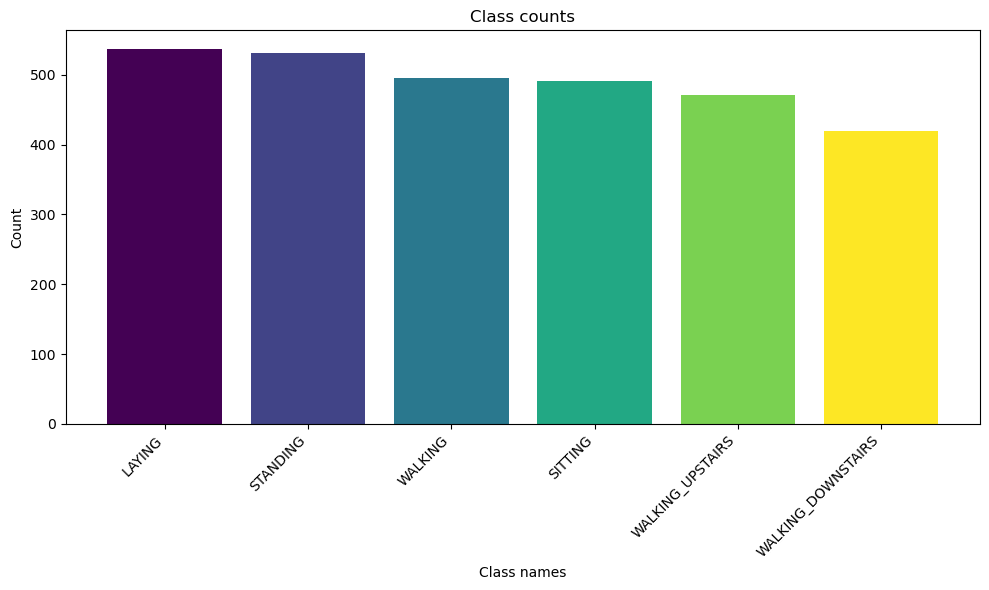

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LAYING
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,537
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720,12.986427,NaN
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467,6.950984,NaN
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228,2.000000,NaN
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485,9.000000,NaN
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671,12.000000,NaN
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373,18.000000,NaN


In [ ]:
analyze_data(df, "Activity")

In [ ]:
pd.DataFrame.from_dict(Counter([col.split('-')[0].split('(')[0] for col in df.columns]), orient='index').rename(columns={0:'count'}).sort_values('count', ascending=False)

,count
fBodyAcc,79
fBodyGyro,79
fBodyAccJerk,79
tGravityAcc,40
tBodyAcc,40
tBodyGyroJerk,40
tBodyGyro,40
tBodyAccJerk,40
tBodyAccMag,13
tGravityAccMag,13


In [ ]:
from sklearn.preprocessing import LabelEncoder

df = df.dropna(subset=[TARGET_CLASS_NAME])
        # Handle missing values in features
for col in df.columns:
    if col != TARGET_CLASS_NAME:
        if df[col].dtype in ['object', 'category']:
            # Fill categorical missing values with mode
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'unknown')
        else:
            # Fill numerical missing values with median
            df[col] = df[col].fillna(df[col].median())

# Encode categorical variables
label_encoders = {}
for col in df.columns:
    if df[col].dtype in ['object', 'category']:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

In [ ]:
df.head(10)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,2
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,2
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,2
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,2
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,2
5,0.279220,-0.018620,-0.113902,-0.994455,-0.970417,-0.965316,-0.994585,-0.969481,-0.965897,-0.937856,...,-0.857565,-0.095681,0.048849,0.760684,-0.072216,-0.689816,0.294896,-0.068471,2,2
6,0.279746,-0.018271,-0.104000,-0.995819,-0.976354,-0.977725,-0.995996,-0.973665,-0.979253,-0.937856,...,-0.391286,-0.309083,-0.000857,0.728514,-0.333771,-0.690085,0.295282,-0.067065,2,2
7,0.274601,-0.025035,-0.116831,-0.995594,-0.982069,-0.985262,-0.995341,-0.981485,-0.984610,-0.941263,...,-0.672358,-0.025526,-0.214033,0.437640,-0.366674,-0.688785,0.295981,-0.067706,2,2
8,0.272529,-0.020954,-0.114472,-0.996784,-0.975906,-0.986597,-0.997029,-0.973735,-0.985556,-0.941263,...,-0.853248,0.144626,-0.035564,-0.181800,0.087320,-0.685390,0.299394,-0.065491,2,2
9,0.275746,-0.010372,-0.099776,-0.998373,-0.986933,-0.991022,-0.998663,-0.987140,-0.991084,-0.943761,...,-0.741435,0.157584,-0.033487,-0.350893,0.343146,-0.684110,0.300822,-0.064263,2,2


### Save processed dataset to CSV

In [ ]:

# Save train or test datasets
df.to_csv('data/processed/multi_class_balanced_human_activity_recognition/' + CURR_FILE_NAME, index=False)

print("Training set shape:", df.shape)
print("Dataset saved to: ", 'data/processed/multi_class_balanced_human_activity_recognition/' + CURR_FILE_NAME)

Training set shape: (2947, 563)
Dataset saved to:  data/processed/multi_class_balanced_human_activity_recognition/test.csv


## OPISAĆ TUTAJ NASZą implementację ensmble runnera #TODO

### Implementacja `EnsembleRunner` i `BaselineRunner`

W ramach naszego projektu zaimplementowaliśmy dwie główne klasy do przeprowadzania eksperymentów: `EnsembleRunner` oraz `BaselineRunner`. `EnsembleRunner` służy do trenowania i testowania modeli zespołowych, takich jak Bagging i Lasy Losowe (Random Forest), podczas gdy `BaselineRunner` pozwala na uruchamianie pojedynczych modeli bazowych (np. Drzewo Decyzyjne) w celu porównania wyników.

Sterowanie eksperymentami odbywa się za pomocą centralnego obiektu konfiguracyjnego. Definiuje on wszystkie kluczowe aspekty, w tym:
- Nazwę eksperymentu
- Ścieżki do danych
- Konfigurację modelu
- Opcjonalne ustawienia dotyczące podzbioru danych oraz hiperparametrów.

Kluczową cechą naszego rozwiązania jest elastyczność. Konfiguracje `dataset_config` (odpowiedzialna za wybór atrybutów) oraz `hyperparameters_config` (odpowiedzialna za definicję przestrzeni hiperparametrów) są opcjonalne.
- Jeśli `dataset_config` nie zostanie podany, model zostanie wytrenowany na wszystkich kolumnach dostępnych w zbiorze danych.
- Jeśli `hyperparameters_config` zostanie pominięty, wykorzystane zostaną domyślne wartości hiperparametrów dla danego modelu.


## Przykładowa konfiguracja eksperymentów


In [12]:
import sys
sys.path.append("../") # go to parent dir
from src.utils.generate_hyperparams import HyperparamsGenerator
from src.utils.generate_data_subset import DataSubsetGenerator
from src.models.decision_tree_model import DecisionTreeModel
from src.utils.common import FLIGHTS_DATASET_TARGET_CLASS_NAME

dataset_conf = {
    'dataset_name': 'data/processed/binary_balanced_airflight_satisfaction/train.csv',
    'dataset_shortname': 'flights',
    'shrunk_size': None,
    'n_attributes_max': 10,
    'n_attributes_min': 10,
    'select_type': 'standard-selection', # or 'sqrt-selection'
    'target_column': FLIGHTS_DATASET_TARGET_CLASS_NAME
}


model_conf = {
    'model_type': DecisionTreeModel,
    'max_depth': {
        'type': 'int',
        'min': 10,
        'max': 20
    },
    'min_samples_split': {
        'type': 'int',
        'min': 2,
        'max': 30
    },
    'min_samples_leaf': {
        'type': 'int',
        'min': 1,
        'max': 30
    },
    'max_features': {
        'type': 'list',
        'options': ['sqrt', 'log2', None]
    },
    'criterion': {
        'type': 'list',
        'options': ['gini', 'entropy']
    },
    'splitter': {
        'type': 'list',
        'options': ['best', 'random']
    }        
}


ensemble_config = {
    'run_id': 0,
    'model_name': 'DecisionTree',
    'seed': 0,
    'n_models': 3,
}

ensemble_config["model_conf"] = model_conf
ensemble_config["dataset_conf"] = dataset_conf 


In [8]:
from src.pipelines.ensemble_runner import EnsembleRunner
from src.utils.dataloader import DatasetLoader
from src.utils.metrics_saver import MetricsSaver

hg = HyperparamsGenerator()
ds = DataSubsetGenerator()
dl = DatasetLoader()
ms = MetricsSaver(experiment_type='CUSTOM')


In [ ]:
ensemble_model = EnsembleRunner(hyperparam_generator=hg, data_sampler=ds, data_loader=dl, metrics_saver=ms)

ensemble_model.run_dataset_experiment(ensemble_config, 1)

# ensemble_config["dataset_conf"]['dataset_name'] = 'data/processed/binary_unbalanced_credit_card_fraud/train.csv',
# ensemble_config["dataset_conf"]['dataset_shortname'] = 'credit_cards'
# ensemble_model.run_dataset_experiment(ensemble_config, 1)

# ensemble_config['dataset_name'] = 'data/processed/multi_class_balanced_human_activity_recognition/train.csv',
# ensemble_config['dataset_shortname'] = 'human_activity'
# ensemble_model.run_dataset_experiment(ensemble_config, 1)
           
# Print summary and save results
ensemble_model.metrics_saver.print_summary()
json_path, csv_path = ensemble_model.metrics_saver.save_results()

print(f"\n✅ Full custom experiments completed!")
print(f"📄 Detailed results: {json_path}")
print(f"📊 Summary: {csv_path}")


**********
flights
**********
Loading dataset: flights
  Train file: ../data/processed/binary_balanced_airflight_satisfaction/train.csv
  Test file: ../data/processed/binary_balanced_airflight_satisfaction/test.csv
Dataset flights loaded successfully:
  Train: (103904, 22), Test: (25976, 22)
  Classes: 2, Features: 22
  Target column: satisfaction
Loading dataset from: ../data/processed/binary_balanced_airflight_satisfaction/train.csv
Original dataset shape: (103904, 23)
Dataset columns before shrinking: ['gender', 'customer_type', 'age', 'type_of_travel', 'class', 'flight_distance', 'inflight_wifi_service', 'departure_arrival_time_convenient', 'ease_of_online_booking', 'gate_location', 'food_and_drink', 'online_boarding', 'seat_comfort', 'inflight_entertainment', 'on_board_service', 'leg_room_service', 'baggage_handling', 'checkin_service', 'inflight_service', 'cleanliness', 'departure_delay_in_minutes', 'arrival_delay_in_minutes', 'satisfaction']
Available feature columns: 22
Standar

FileNotFoundError: Dataset file not found: ('data/processed/binary_unbalanced_credit_card_fraud/train.csv',)

In [ ]:
            
        # # Print summary and save results
        # self.metrics_saver.print_summary()
        # json_path, csv_path = self.metrics_saver.save_results()
        
        # print(f"\n✅ Full custom experiments completed!")
        # print(f"📄 Detailed results: {json_path}")
        # print(f"📊 Summary: {csv_path}")
        

# Full Baseline Experiments

In [2]:
from src.pipelines.baseline_runner import BaselineExperimentRunner

runner = BaselineExperimentRunner()
results = runner.run_full_baseline_experiments()  # Note: different method name

print("\n🎉 All baseline experiments completed!")
print("Check 'results/baseline/' directory for detailed results")

# Show quick summary
successful_experiments = sum(1 for dataset_results in results.values() 
                           if 'error' not in dataset_results)
total_experiments = len(results)

print(f"\nExperiment Summary:")
print(f"  Successfully processed: {successful_experiments}/{total_experiments} datasets")

if successful_experiments > 0:
         print(f"  Results saved to: results/baseline/")
         print(f"  View detailed results in the JSON and CSV files")

🔬 Starting Full Baseline Experiments

📊 Processing dataset: flights
Loading dataset: flights
  Train file: data/processed/binary_balanced_airflight_satisfaction/train.csv
  Test file: data/processed/binary_balanced_airflight_satisfaction/test.csv
Dataset flights loaded successfully:
  Train: (103904, 22), Test: (25976, 22)
  Classes: 2, Features: 22
  Target column: satisfaction
  Training bagging_10...
BaggingClassifier fitted on data shape (103904, 22)
    ✅ Accuracy (Test): 0.9207, F1 (Test): 0.9203
    ✅ Accuracy (Train): 0.9966, F1 (Train): 0.9966
  Training bagging_50...
BaggingClassifier fitted on data shape (103904, 22)
    ✅ Accuracy (Test): 0.9197, F1 (Test): 0.9193
    ✅ Accuracy (Train): 0.9999, F1 (Train): 0.9999
  Training bagging_100...
BaggingClassifier fitted on data shape (103904, 22)
    ✅ Accuracy (Test): 0.9201, F1 (Test): 0.9197
    ✅ Accuracy (Train): 1.0000, F1 (Train): 1.0000
  Training random_forest_10...
RandomForestClassifier fitted on data shape (103904, 22

# Presentation of results

In [6]:
from src.utils.create_results_tables import generate_results

generate_results()

🎯 Results Table Generator
📊 Loading baseline data from: baseline_summary_20250608_230203.csv
📊 Loading custom data from: custom_summary_20250608_230502.csv
✅ Loaded data: 2 records
📊 Datasets: ['flights']
🔬 Models: ['DecisionTree_av_test']

📋 RESULTS TABLES BY DATASET
Format: Train Score | Test Score (N/A if not available)

📊 Creating table for flights dataset...


TypeError: agg function failed [how->mean,dtype->object]

## Resulsts Visualization

📊 Loading data...
📊 Loading baseline data from: baseline_summary_20250607_142407.csv
📊 Loading custom data from: custom_ensemble_v1_20250606_003216.csv

📈 ENSEMBLE METHODS SUMMARY

CREDIT_CARDS:
  Random Forest models: 3 (random_forest_10, random_forest_50, random_forest_100)
  Bagging models: 3 (bagging_10, bagging_50, bagging_100)
  Best test accuracy: 0.9996 (bagging_100)

FLIGHTS:
  Random Forest models: 3 (random_forest_10, random_forest_50, random_forest_100)
  Bagging models: 3 (bagging_10, bagging_50, bagging_100)
  Best test accuracy: 0.9502 (random_forest_100)

HUMAN_ACTIVITY:
  Random Forest models: 3 (random_forest_10, random_forest_50, random_forest_100)
  Bagging models: 3 (bagging_10, bagging_50, bagging_100)
  Best test accuracy: 0.9270 (random_forest_100)

📈 Creating custom experiment comparison plots...

📊 Creating plots for credit_cards dataset...
  📈 Creating plot for rf_attr...
    💾 Saved: plots/custom_comparisons/credit_cards_rf_attr_vs_baseline.png

📊 Creating p

/var/folders/b_/6hg48zw14yz957yrgs4mg_xc0000gn/T/ipykernel_35460/3530163630.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


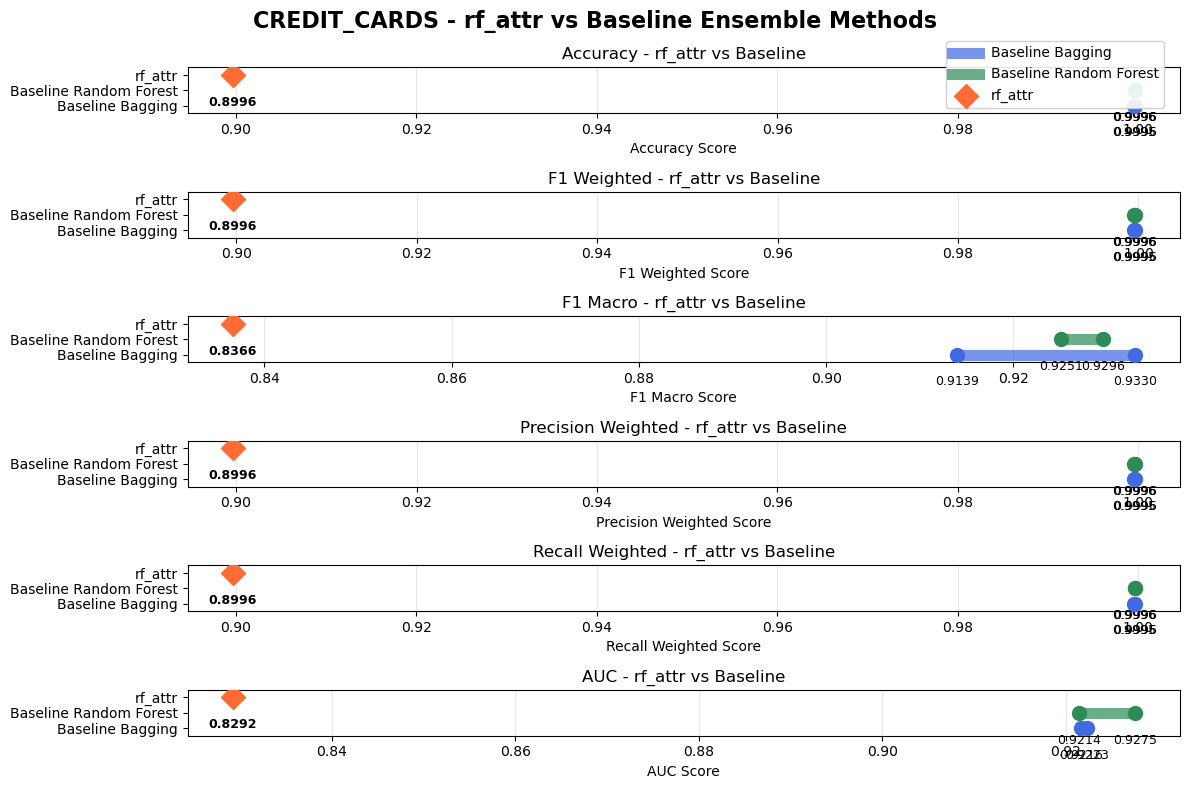

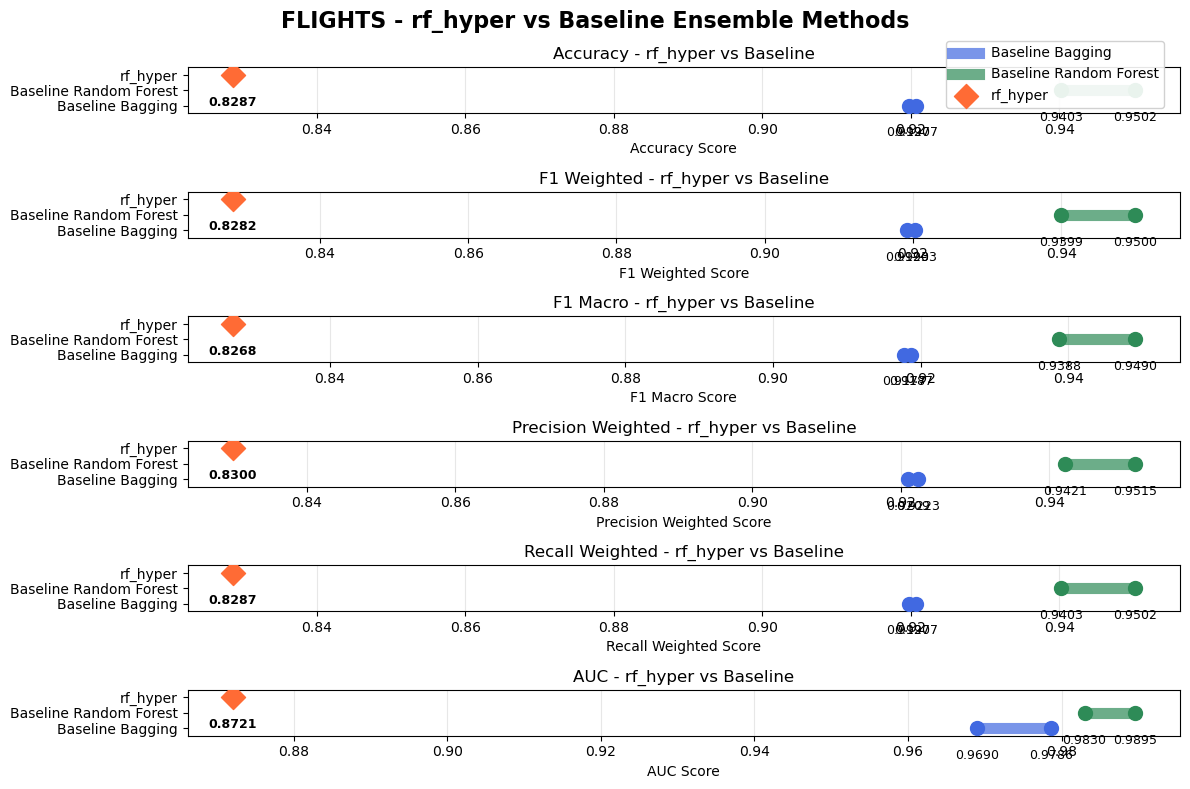

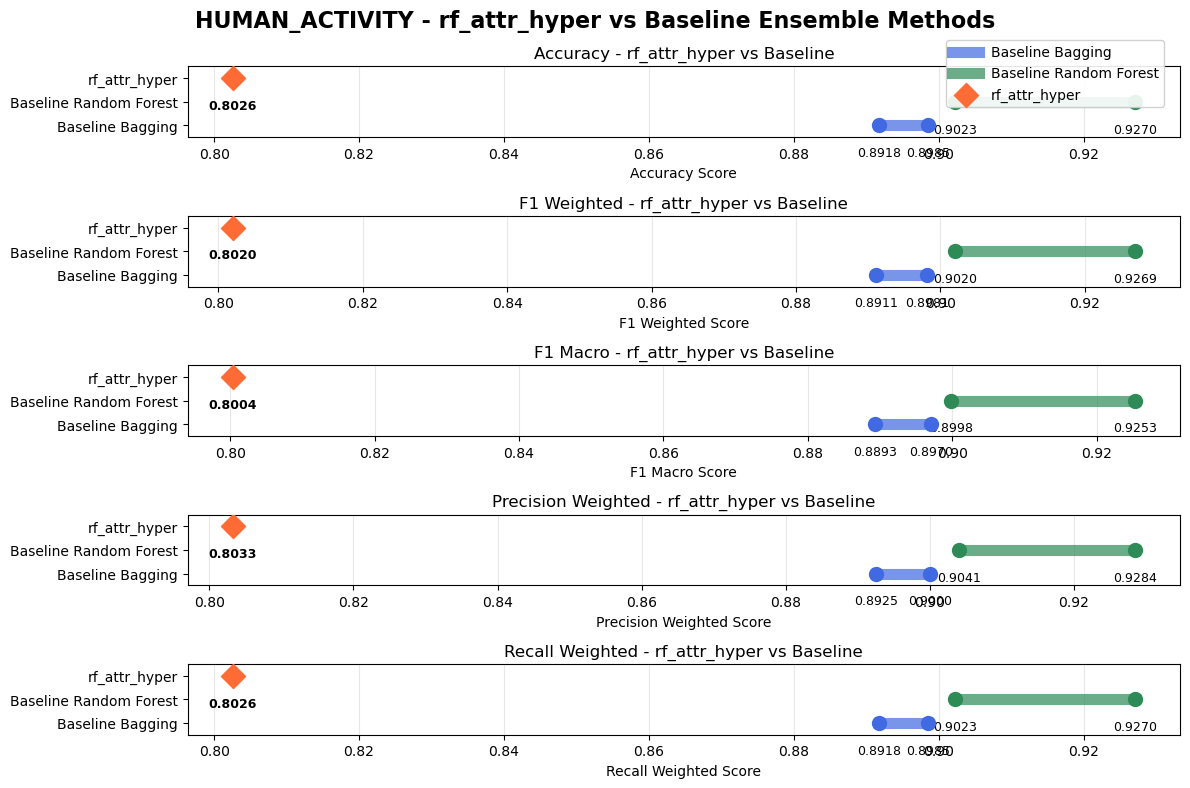

In [7]:
from src.utils.results_visualizer import EnsembleResultsVisualizer
from matplotlib import pyplot as plt

visualizer = EnsembleResultsVisualizer(results_dir="results")

# Load data and show summary
print("📊 Loading data...")
visualizer.load_data()
visualizer.show_summary_stats()

print("\n" + "=" * 50)
print("📈 Creating custom experiment comparison plots...")

# Create custom experiment comparison plots
custom_figures = visualizer.create_custom_experiment_plots(save_plots=True)

# Display the plots
total_custom = sum(len(figs) for figs in custom_figures.values()) if custom_figures else 0

if custom_figures:
    print(f"\n✅ Created {total_custom} custom comparison plots!")
    print("🖼️  Displaying plots...")
    
    # Show custom experiment plots
    for dataset, dataset_figs in custom_figures.items():
        for experiment, fig in dataset_figs.items():
            fig.show()
            
    plt.show()
else:
    print("⚠️  No plots were created. Check your data and try again.")